In [139]:
!pip install mdct

In [120]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.signal import hamming
from scipy.spatial.distance import cdist

import IPython.display as ipd
from mdct.fast import mdct, imdct
from scipy.io.wavfile import write

plt.rcParams['figure.figsize'] = (12,8)

In [121]:
# useful functions

def plot_sound(data, rate, title=None):
    if data.ndim == 1:
        data = data[:,np.newaxis]
    times = np.arange(data.shape[0])/rate
    plt.figure(figsize=(30,6))
    for channel in data.T:
        plt.fill_between(times, channel)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(times[0], times[-1])
    if title:
        plt.title(title)
    plt.show()
    
def play_sound(data, rate):
    return ipd.Audio(data.T, rate=rate)

T = 220501, M = 2


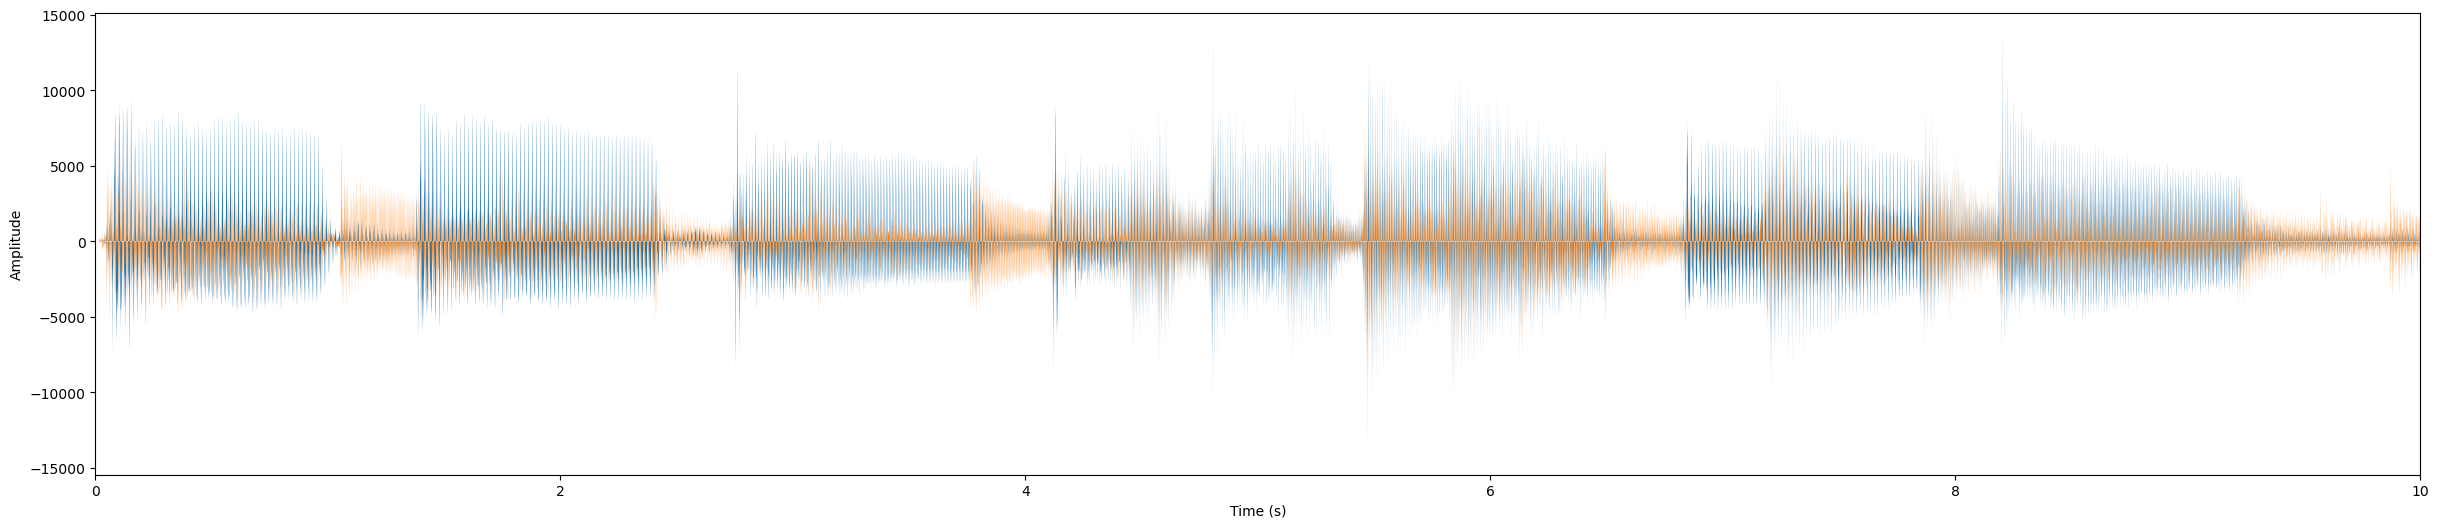

In [122]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

In [123]:
write('new_mix.wav', rate, np.array(x, dtype=np.int16)) # to write a new wave file

In [124]:
T = 220501
M = 2

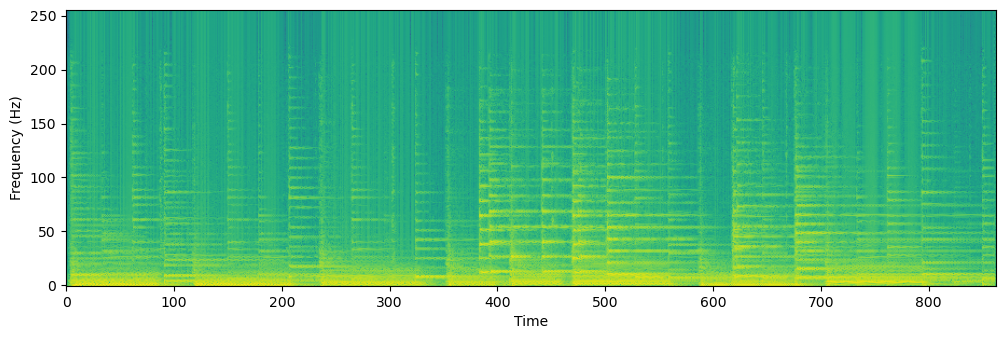

In [125]:
X = mdct(x, window=hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

X_norm = np.abs(Z)**2

plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

## **1. Mixture model and principle of the DUET method**

## **2. Work to do**

### 1. Opening the audio

T = 220501, M = 2


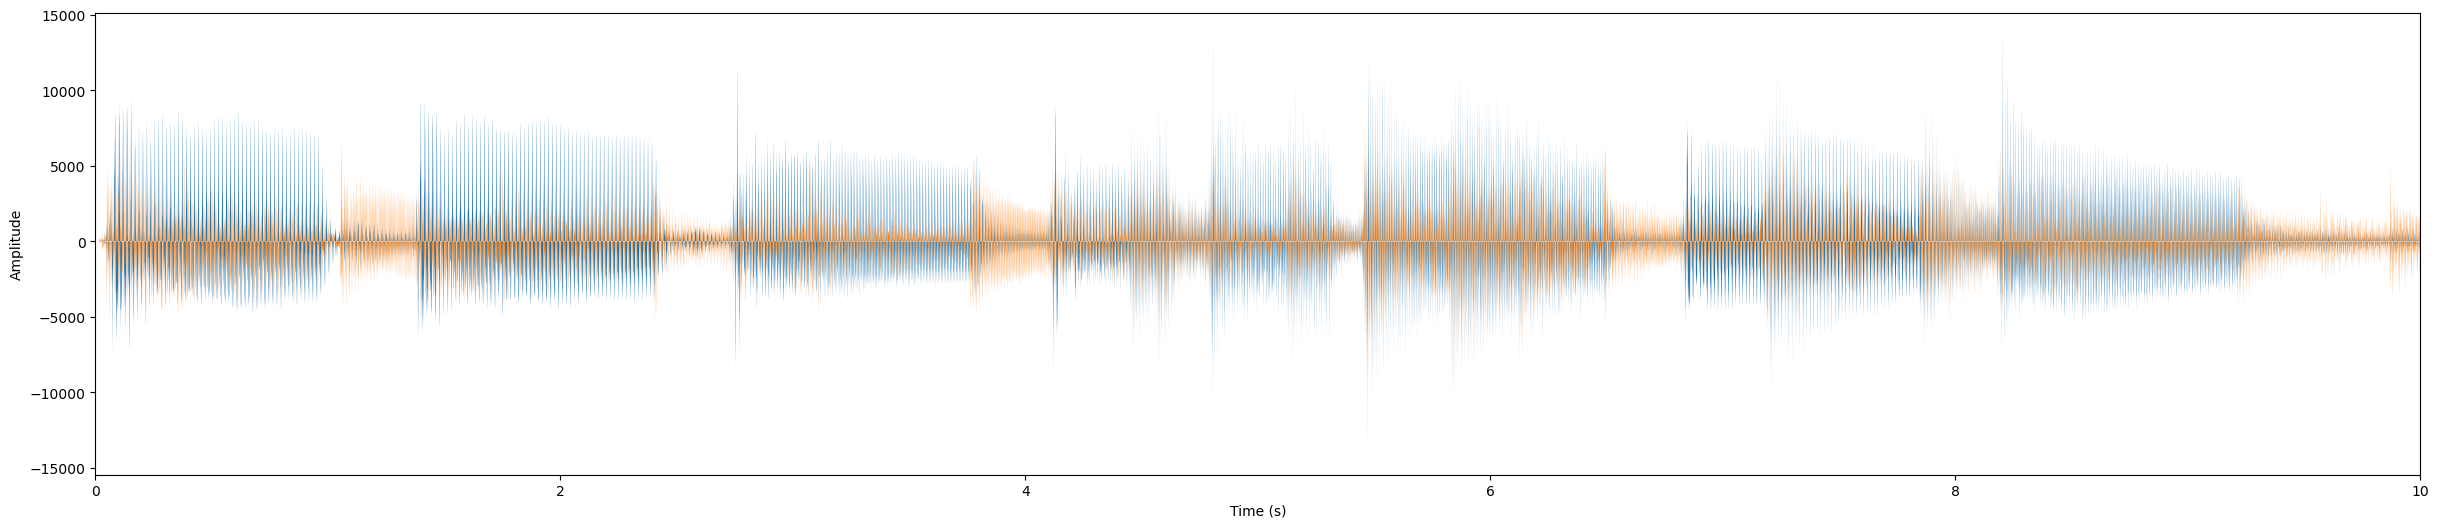

In [126]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

 I can hear $K =$ instruments. I perceive them from ...

### 2. Temporal Dispersion Diagram

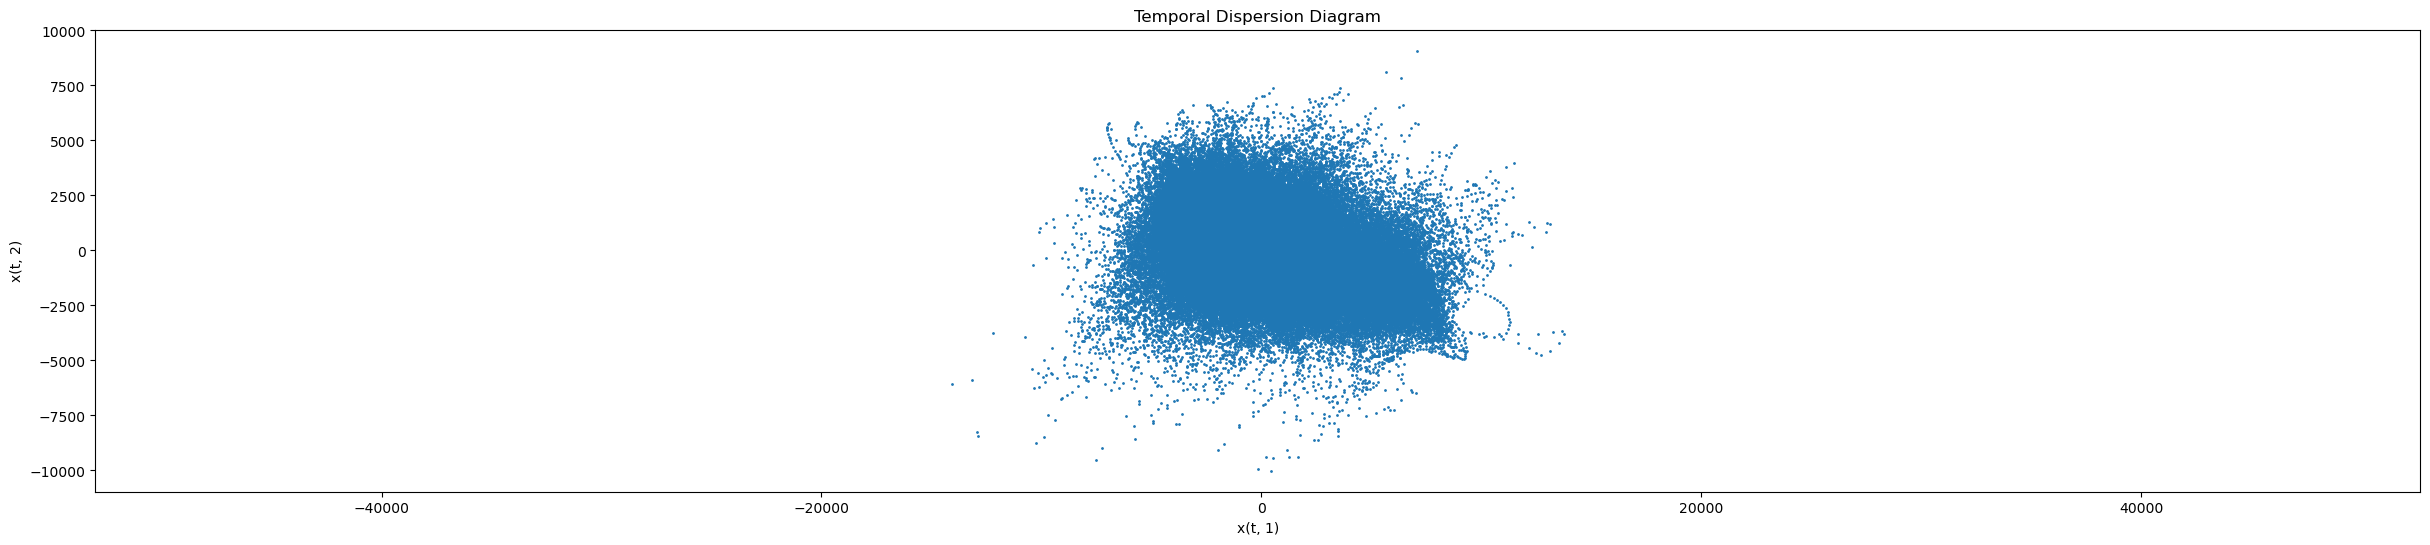

In [127]:
x1 = x[:,0]
x2 = x[:,1]

plt.figure(figsize=(30,6))
plt.scatter(x1, x2,s=1)
plt.axis('equal')
plt.xlabel('x(t, 1)')
plt.ylabel('x(t, 2)')
plt.title('Temporal Dispersion Diagram')
plt.show()

I cannot really distinguish the directions of the sources, there is no separate clusters for each source. The sources are not well separated.

### 3. Computing the MDCT

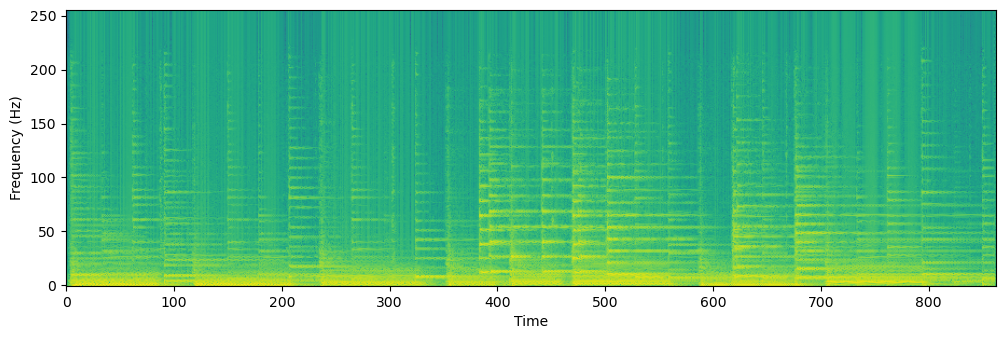

In [128]:
X = mdct(x, window=hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

X_norm = np.abs(Z)**2

plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

### 4. Time-Frequency Dispersion Diagram

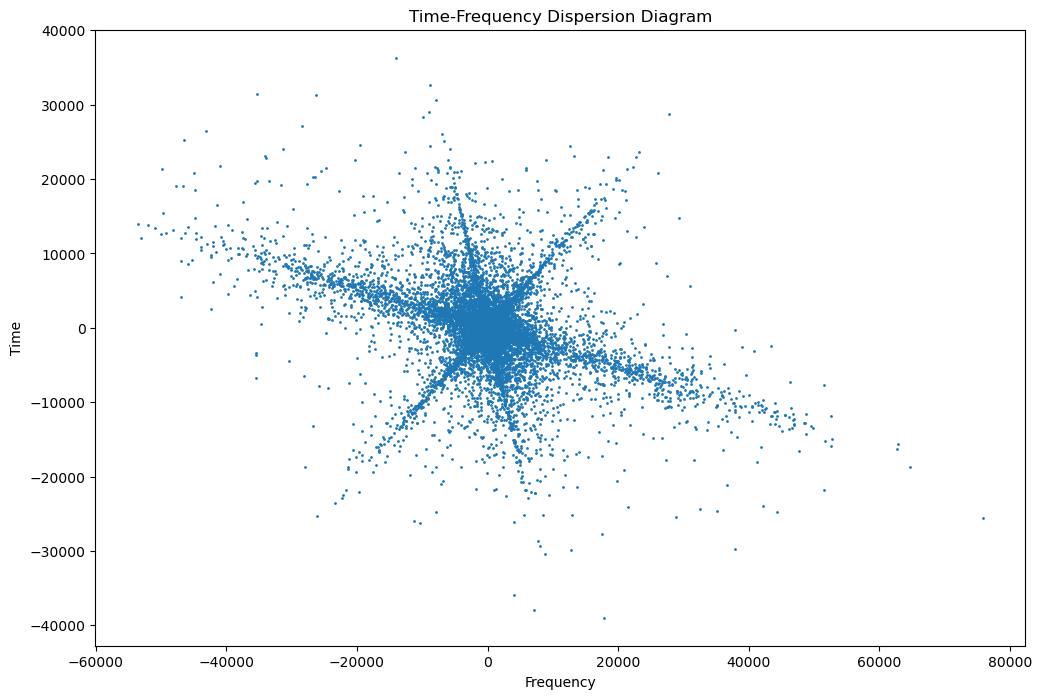

In [129]:
plt.scatter(Z.real, Z.imag, s=1)

plt.ylabel('Time')
plt.xlabel('Frequency')
plt.title('Time-Frequency Dispersion Diagram')
plt.show()

Here, we can clearly distinguish 3 directions of sources. They are well separated. This distinction with the temporal dispersion diagram is explainable because here we listen to a piece of music when we have a clearly discrete distrubution of frequencies. Thus the disctinction appears clearly in the TF domain.

### 5. Histogram of arguments

/var/folders/wz/mdj42wg170j7vt8s9ljnyn580000gn/T/ipykernel_99941/4088412866.py:2: RuntimeWarning: invalid value encountered in divide
  plt.hist(np.arctan(Z_flattened.imag/Z_flattened.real), bins=1000, label='arg')


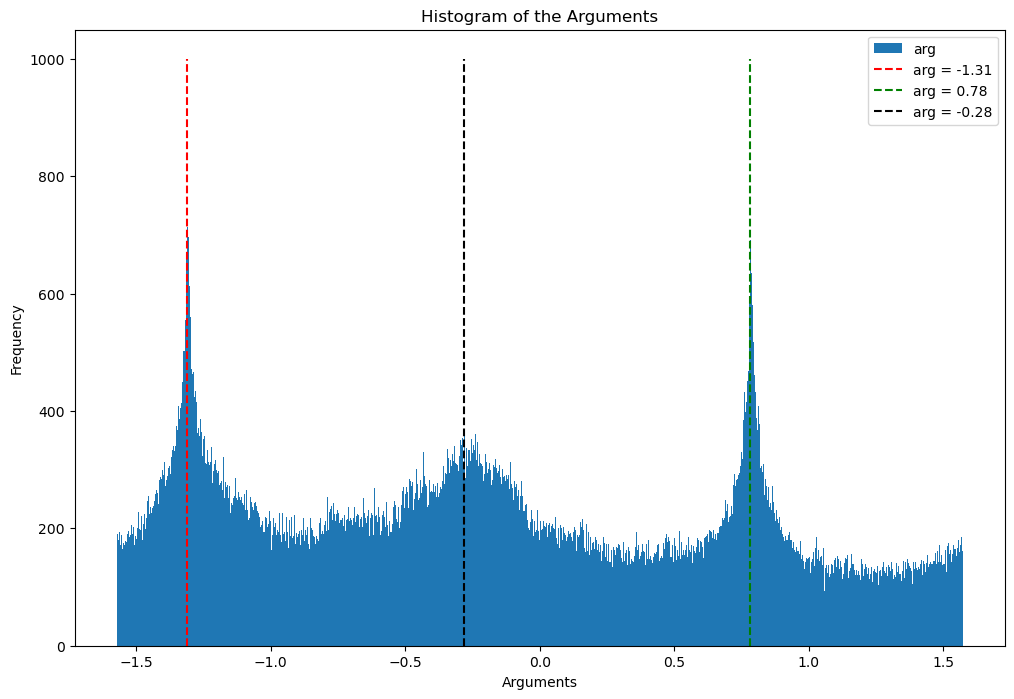

In [130]:
Z_flattened = Z.flatten()
plt.hist(np.arctan(Z_flattened.imag/Z_flattened.real), bins=1000, label='arg')
plt.vlines(-1.31, 0, 1000, colors='r', linestyles='dashed', label='arg = -1.31')
plt.vlines(0.78, 0, 1000, colors='g', linestyles='dashed', label='arg = 0.78')
plt.vlines(-0.28, 0, 1000, colors='black', linestyles='dashed', label='arg = -0.28')
plt.xlabel('Arguments')
plt.ylabel('Frequency')
plt.title('Histogram of the Arguments')
plt.legend()
plt.show()

The angles are :
$$-1.31$$
$$-0.28$$
$$0.78$$

### 6.

In [131]:
angle = np.array([-1.31, 0.78, -0.28])
arguments = np.arctan(Z.imag/Z.real)
K = 3
bins = np.linspace(-np.pi/2, np.pi/2, 1000)



# Deviation measure 
measure = np.array([[[np.abs(np.sin(angle[0] - arguments[i, j])),
                        np.abs(np.sin(angle[1] - arguments[i, j])),
                        np.abs(np.sin(angle[2] - arguments[i, j]))] for j in range(arguments.shape[1])] for i in range(arguments.shape[0])])
# Find the closest angle according to the deviation measure
nearest = np.argmin(measure, axis=2)

# Create the masks
B = np.zeros((arguments.shape[0], arguments.shape[1], K))
for f in range(arguments.shape[0]):
	for n in range(arguments.shape[1]):
		B[f, n, nearest[f, n]] = 1
  


/var/folders/wz/mdj42wg170j7vt8s9ljnyn580000gn/T/ipykernel_99941/535165746.py:2: RuntimeWarning: invalid value encountered in divide
  arguments = np.arctan(Z.imag/Z.real)


### 7.

In [141]:


Y = np.zeros((X.shape[0], X.shape[1], X.shape[2], K))
for f in range(X.shape[0]):
    for n in range(X.shape[1]):
        for m in range(X.shape[2]):
            for k in range(K):
                Y[f, n, m, k] = B[f, n, k] * X[f, n, m]

                
y = np.zeros((T,M,K))
for k in range(K):
    for m in range(M):
        y[:,m,k] = imdct(Y[:,:,m,k], window=hamming, framelength=512)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [133]:
import numpy as np
from mdct import imdct

# Assuming X is the MDCT coefficients array of shape (num_bins_f, num_bins_n, num_channels)
# Assuming B is the binary masks array of shape (num_bins_f, num_bins_n, num_sources)
# Assuming K is the number of sources

num_bins_f, num_bins_n, num_channels = X.shape
num_sources = B.shape[-1]
T = X.shape[0] * 2
M = X.shape[2]

Y = np.zeros((num_bins_f, num_bins_n, num_channels, num_sources))
for f in range(num_bins_f):
    for n in range(num_bins_n):
        for m in range(num_channels):
            for k in range(num_sources):
                Y[f, n, m, k] = B[f, n, k] * X[f, n, m]

y = np.zeros((T, M, num_sources))
for k in range(num_sources):
    for m in range(M):
        y[:, m, k] = imdct(Y[:, :, m, k], framelength=512)



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices